# Lab 12: The Markov chain Monte Carlo (MCMC) method

**Please enter your name and student number in the markdown cell below** then press `Shift` + `Enter`.

- Name:    Elif Solmaz
- SID:     220467249



### Do This Before You Start:

1. Read - [Introduction to Metropolis-Hastings Algortithm (from Computational Physics by Newman 2012)](https://qmplus.qmul.ac.uk/pluginfile.php/3382908/mod_resource/content/2/newman_montecarlo.pdf)
1. View Video Lecture - [Monte Carlo Methods](https://qmplus.qmul.ac.uk/mod/kalvidres/view.php?id=2070914) (Video),   [Lecture Slides](https://qmplus.qmul.ac.uk/pluginfile.php/3382907/mod_resource/content/2/Random-Monte-Carlo.pdf) (PDF)

## Markov chain Monte Carlo optimisations

Optimising or finding the minima of functions is a surprising application of the use of random numbers.  These types of simulations find use in a variety of areas of statistical physics, quantum mechanics, and strangely enough curve fitting.

The general strategy for finding the minimum of a function $F$ is the following.  We make a guess at the initial variables and compute the value of the function $F$.  We then conduct a random walk in these variables, accepting those moves that reduce the value of F as well as some small random fluctuations to larger values of $F$.  This random walk through parameters is continued until the parameters converge and fluctuate around a fixed value.  This strategy for minimisation utilises random numbers to explore parameter values without bias, to generate fluctuations that allow the solution to escape local minima in parameter space, and provides a distribution of states around minima.

The mathematical foundations for why and how this model works are a little beyond the scope of this module (*e.g.*, how to choose the acceptance rate, how to analyse the distribution of states produced - see the scan from *Computational Physics* by Newman on the QM+ page for a more complete development).  However, the algorithm is simple enough that we can see how it functions and produces a reasonable result for increasingly complicated problems.

We will use a variant of the *Metropolis-Hastings* algorithm.  This type of Markov chain Monte Carlo simulation involves the following steps:

1. Choose a starting state, which we’ll call state 0.
2. *Propose* a move at random from an allowed set of moves. This would take the system from state $i$ to a new state $i+1$.
3. Calculate the value of the *acceptance probability* $P_\mathrm{a}$
$$
    P_\mathrm{a} = \begin{cases}
                 1 & \text{if}\qquad F_{i+1} < F_i  \\
                 \exp\{-\beta(F_{i+1} - F_{i})\} & \text{if}\qquad  F_{i+1} \geq F_i
          \end{cases}
$$
where $F_i$ is the value of the function $F$ at state $i$. In other words, if we find a lower value of the function, we will certainly accept the move; if we find a higher value, there is still some probability that we will accept it, depending on how much higher it is and on the value of the acceptance parameter $\beta$.
4. With probability $P_\mathrm{a}$ *accept* the proposed move, and change the state of the system to the new one; otherwise reject it, meaning the system stays in the current state for one more step of the calculation.
5. Measure the value of the quantities of interest in the current state and add it to a running sum of such measurements (or store the values of the chain and analyse them later).
6. Repeat from step 2 until the value of $F_i$ effectively converges.

This process produces a series of states of the system, or a *Markov chain* of states.

The process is a random walk through parameter space.  However, not all steps are accepted; only those that optimise our global function $F$ with some allowance for fluctuations that are controlled through the step sizes and the acceptance coefficient $\beta$.

For our simple version of this algorithm we will store all states of the system and analyse them when we are done iterating.

## A 2D function with multiple minima

Here we'll use a simple illustrative example of the method to find the minima of a 2-d function that has multiple local minima in addition to its global minimum.  
$$
  \text{func_2d}(x,y) = r^2 \bigg(1 - \tfrac{1}{2}\sin^2 \left( \frac{\pi r}{5} \right) \bigg)
$$
where
$$
    r^2 = x^2 + y^2
$$
By inspection this function clearly has a global minimum at $(0,0)$, but due to the oscillating $\sin$ function has infinitely many other local minima, which form concentric circles in the $xy$ plane.  In general, this is a tricky problem to solve with standard approaches that can be “fooled” by local minima if we do not make an initial guess close enough (*e.g.*, think how Newton-Raphson would respond to this shape).  In higher-dimensional parameter spaces  visualisation becomes problematic.  So, here we use the simple 2-D function above to illustrate the method.

**Complete the function `func_2d` below with the mathematical function listed above.**

**Make a 3D surface plot of the function using the code below, plotting in the range $-25 \leq x, y \leq 25$, and visually confirm the location of the global and local minima.**  



In [1]:
import numpy as np
from numpy.random import random, seed

import matplotlib.pyplot as plt


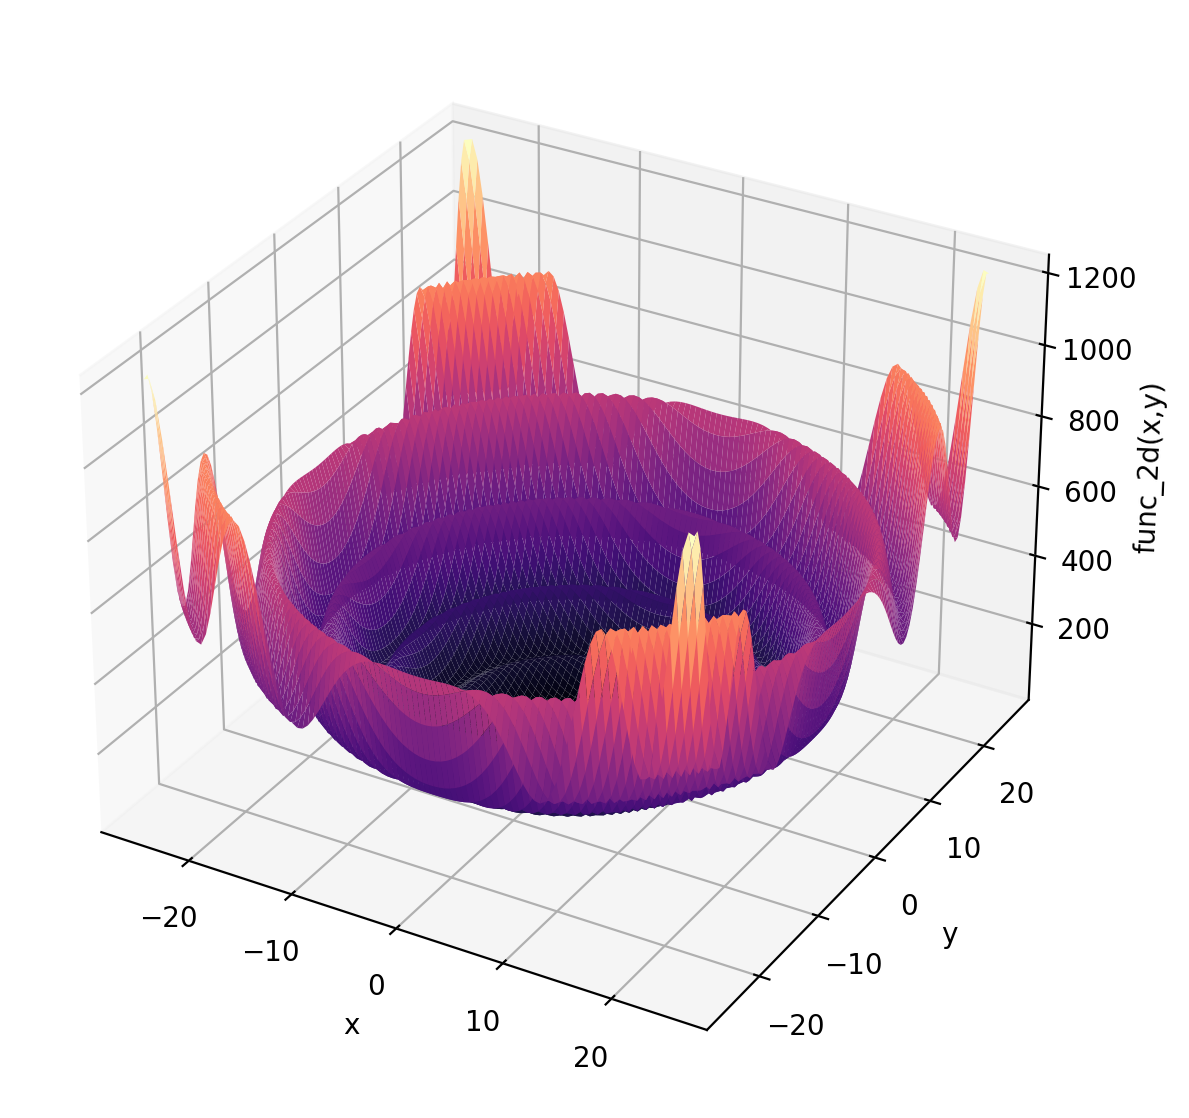

In [2]:
from mpl_toolkits.mplot3d import Axes3D

def func_2d(x, y):
    r_squared = x**2 + y**2
    r = np.sqrt(r_squared)
    return r_squared * (1 - 0.5 * np.sin(np.pi * r / 5)**2)

x = np.linspace(-25, 25, 100)
y = np.linspace(-25, 25, 100)

X, Y = np.meshgrid(x, y)
Z = func_2d(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='magma', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('func_2d(x,y)')

plt.show()


###  Finding the minimum of a function of more than one variable

Here we seek to minimize the function `func_2d` with respect to some parameters ($x$ and $y$ in this case).  In general, finding the minimum of a function in more than one dimension is difficult. 

We deliberately start the function off some way from the global minimum, at $x = y = 12$ which is near the second “ring” minimum. At each step we allow both $x$ and $y$ to vary by up to $\pm 1$.

Initially we will use a value of $\beta = 0.1$ and run our Markov chain for 100 000 steps.



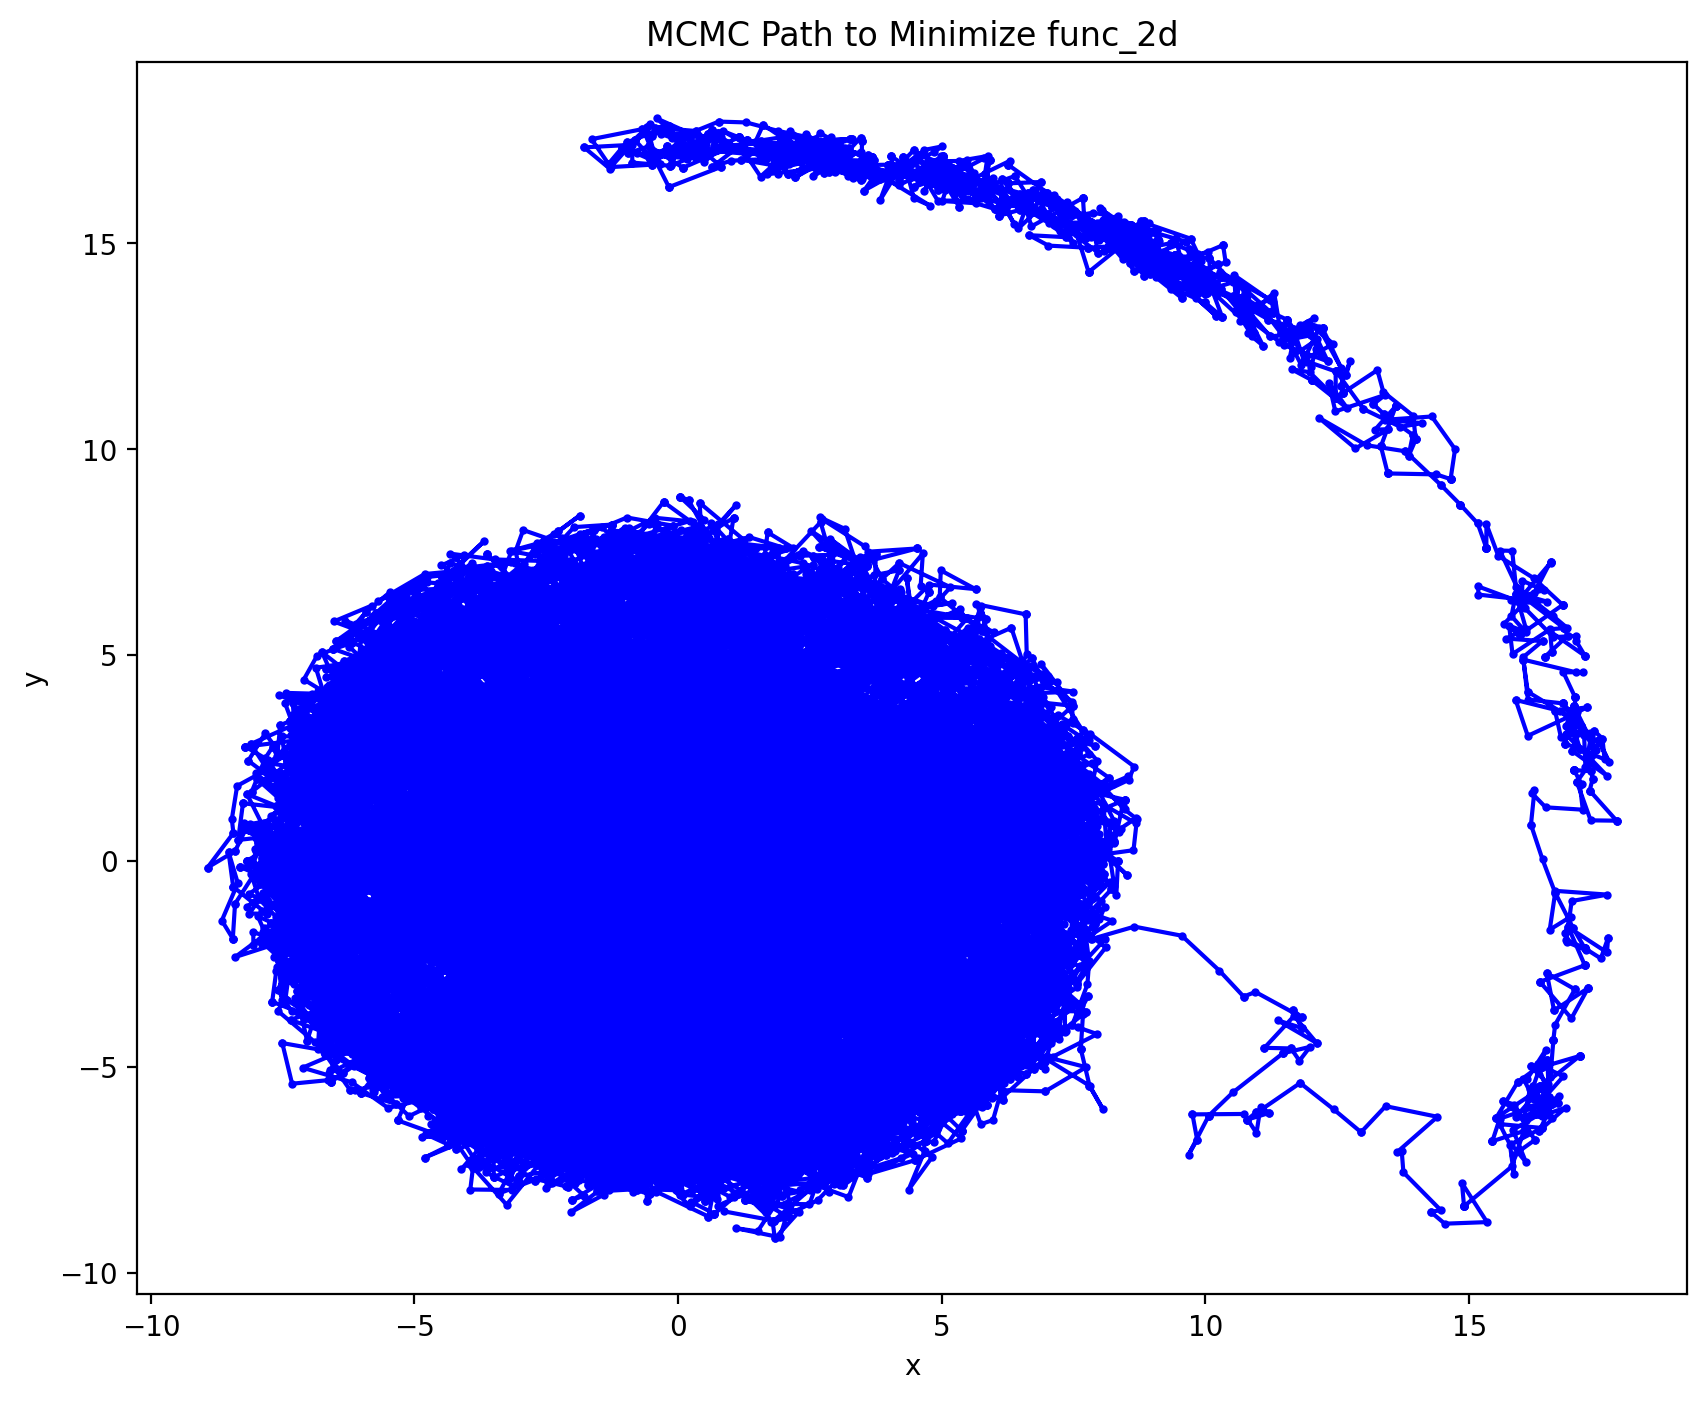

In [3]:
beta = 0.1
steps = 100000
x_current, y_current = 12, 12

def acceptance_probability(F_current, F_new):
    if F_new < F_current:
        return 1
    else:
        return np.exp(-beta * (F_new - F_current))

path_x, path_y, path_z = [x_current], [y_current], [func_2d(x_current, y_current)]

np.random.seed(0)
for _ in range(steps):
    x_new = x_current + np.random.uniform(-1, 1)
    y_new = y_current + np.random.uniform(-1, 1)

    F_current = func_2d(x_current, y_current)
    F_new = func_2d(x_new, y_new)

    if np.random.rand() < acceptance_probability(F_current, F_new):
        x_current, y_current = x_new, y_new

    path_x.append(x_current)
    path_y.append(y_current)

path_x = np.array(path_x)
path_y = np.array(path_y)

fig = plt.figure(figsize=(10, 8))
#ax = fig.add_subplot(111, projection=3d')
#ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='magma', alpha=0.6, edgecolor='none')
plt.plot(path_x, path_y, color='blue', marker='o', markersize=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('MCMC Path to Minimize func_2d')
plt.show()


This path taken through the parameter space – in this case the $xy$-plane – is the “chain” of states that we will analyse. Can you see the chain initially explore the “ring” before, hopefully, eventually finding the central minimum?

The portion of the path or chain where the state changes by large steps before finding the minimum is commonly referred to as the “burn-in”.  The parts of the chain where the solution is fluctuating about the function's minimum is referred to as 'the posterior'.  Analysing the posterior can provide information both about the coordinates in phase space (again $x-y$ in this simple example) where the minimum exists. The distribution of states as the simulation fluctuates around the minima reflect the probability distribution of possible states. 

**Plot the value of the function against the log of the iteration number, or index of the state in the chain.  Identify the “burn in” portion of the chain and the “posterior”.**  

*Hint:* To make this *semi-log* plot, it is easiest to use `plt.semilogx()`; as always, see `?plt.semilogx()` for information on how to use this. You don’t actually need to specify $x$ values since by default `matplotlib` will plot against index.



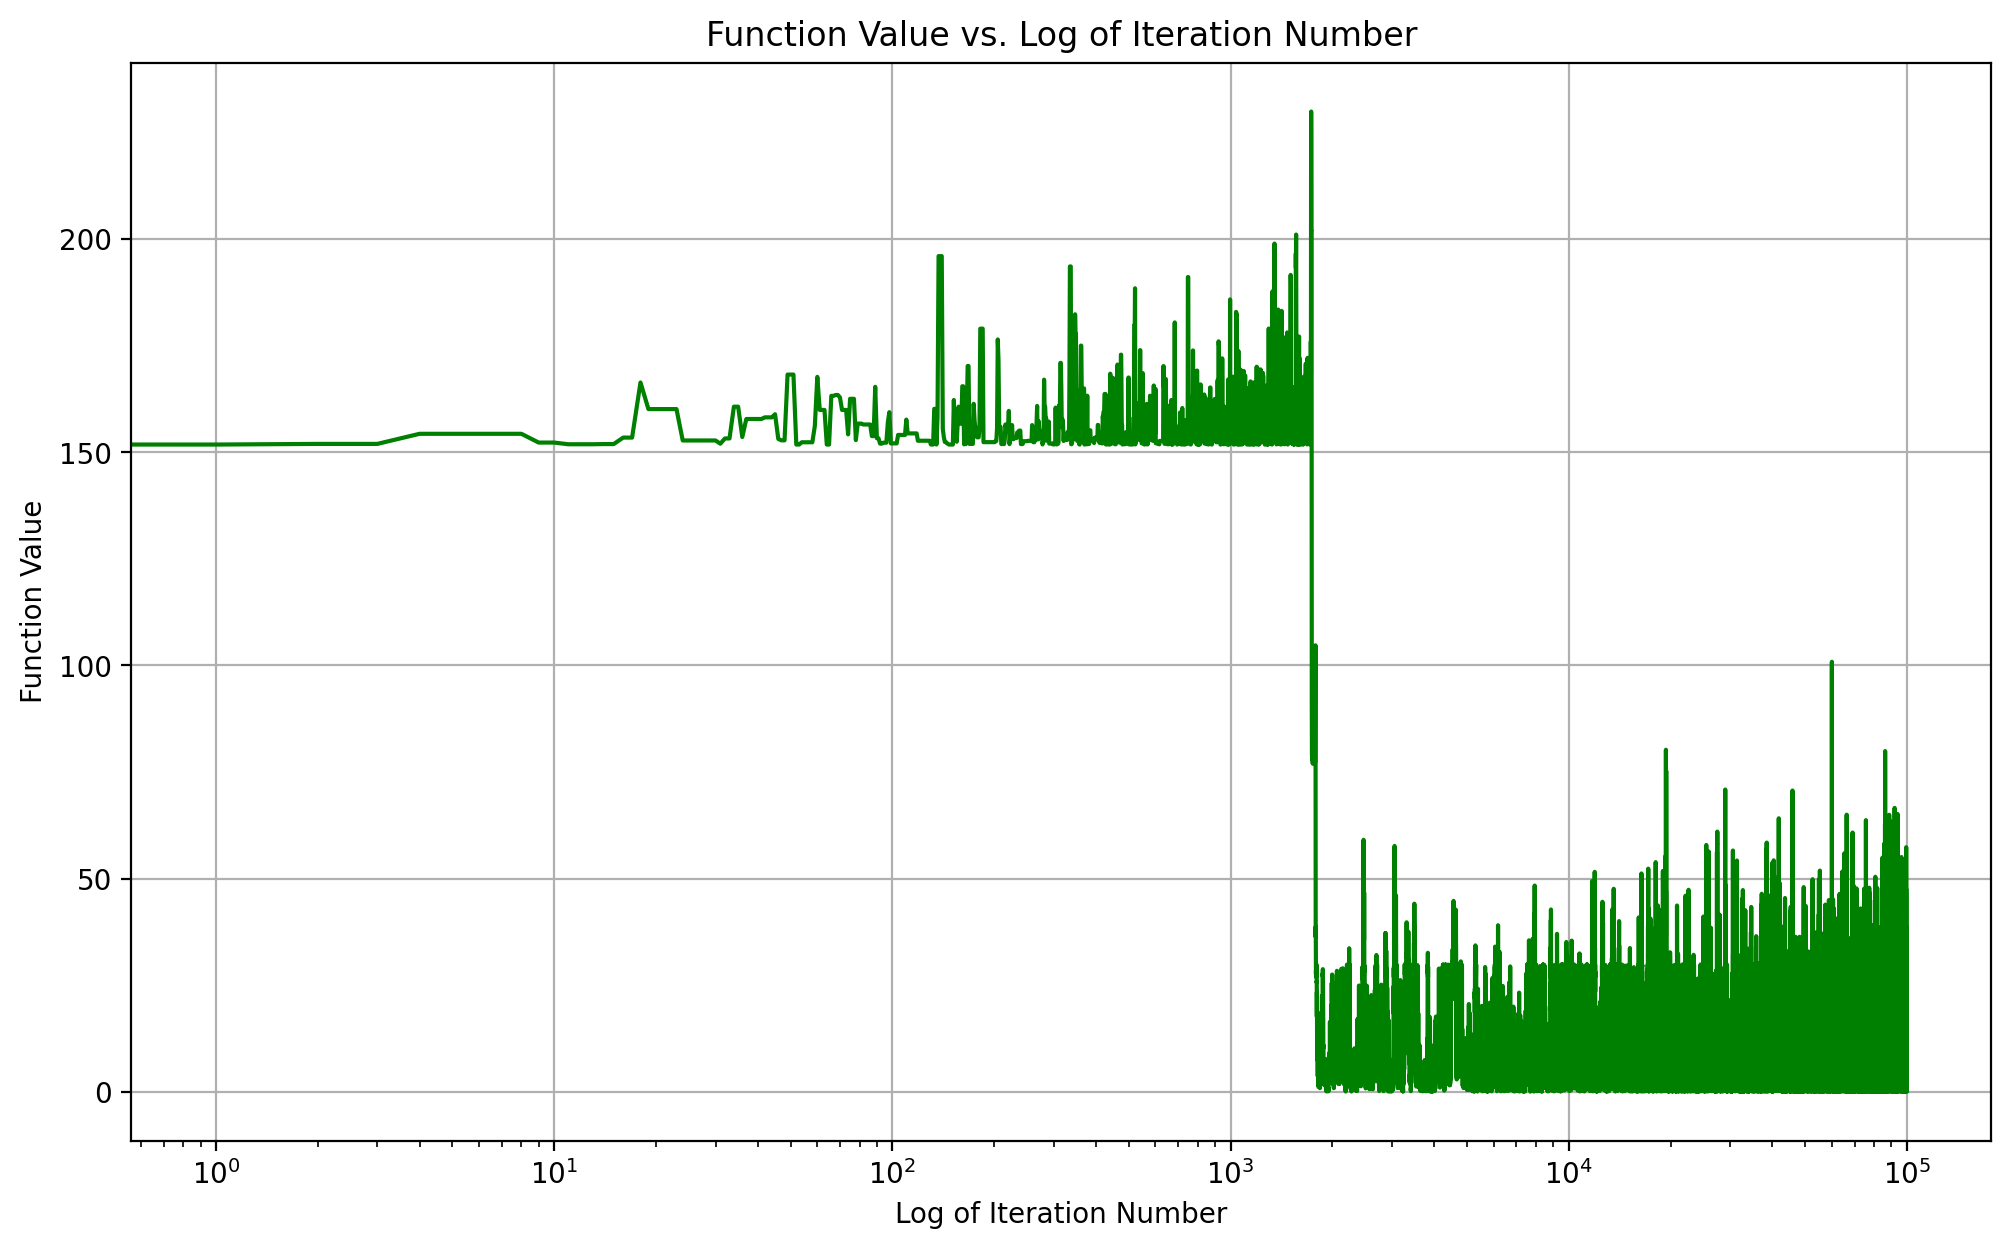

In [4]:
F = func_2d(path_x, path_y)

plt.figure()
plt.semilogx(F, color='green')
plt.title("Function Value vs. Log of Iteration Number")
plt.xlabel("Log of Iteration Number")
plt.ylabel("Function Value")

plt.grid(True)
plt.show()


### Isolating the posterior distribution

If your model appears to have converged to and fluctuate about a global minimum you can analyse distribution of all the states in the chain to identify a best single solution and the distribution about it.

To do this you will need to 'slice' off 'the burn in' phase of the chain and the first bit of 'the posterior.'

The basic requirements in slicing here are that, 

- you slice far enough away from the initial state that it is forgotten in the posterior part of the chain, and 

- you have enough points around the minimum to characterise the distribution there.

**Using your plot of the $f(x,y)$ vs. $\log(i)$ identify a suitable array index to slice your chain and store the posterior in new arrays**.



In [5]:
islice = 15000

xpost = path_x[islice:]
ypost = path_y[islice:]
Fpost = F[islice:]



You will now do some basic analysis on this distribution of points in the chain to characterise the optimal values (ones that find the minima in the function).

Again, you may find the `np.argmin` function helpful here. Recall from previous labs that given a list or array of values `A`, the smallest value is `np.min(A)`, and the *index* of this smallest value is `np.argmin(A)`. (In the case of an array, `A.min()` and `A.argmin()` also work.) This is illustrated in the cell below. **Run it a few times to see how this works.**

In [6]:
seed()    

A=random(6)
print("6 random numbers = \n ",A)
imin = np.argmin(A)
print("The minimum value is in element {:2d} and has value {:20.16f}".format(imin,A[imin]))


6 random numbers = 
  [0.38560409 0.94743417 0.2158123  0.092169   0.46978015 0.06376876]
The minimum value is in element  5 and has value   0.0637687567896381


**Find the values of $x$ and $y$ that provide the minimum value of the function.  Using nicely formatted output print the following:**

- the values of the function at this location
- the average values of $x$ and $y$ in the posterior distribution.



In [7]:
min_index = np.argmin(Fpost)
min_F = Fpost[min_index]
min_x = xpost[min_index]
min_y = ypost[min_index]

avg_x = np.mean(xpost)
avg_y = np.mean(ypost)

print(f"Minimum value of the function: {min_F:.4f}")
print(f"Location of minimum (x, y): ({min_x:.4f}, {min_y:.4f})")
print(f"Average value in the posterior distribution:")
print(f"    Average x: {avg_x:.4f}")
print(f"    Average x: {avg_y:.4f}")

Minimum value of the function: 0.0000
Location of minimum (x, y): (0.0061, 0.0025)
Average value in the posterior distribution:
    Average x: 0.0184
    Average x: -0.0204


### Graphical analysis of the posterior distribution

The distribution of states in the posterior portion of the chain contains statistical information about the solution.  In statistical physics simulations states reflect the distribution of states (e.g., the Maxwell-Boltzmann distribution).  In the usage here these states may reflect the uncertainty in the 'best' solution.  The distributions may also be affected by the step sizes, the acceptance conditions (e.g. $\beta$) and other aspects of the model.

**Plot histograms of $x$ and $y$ of the posterior solution** using `plt.hist()`. 

**What shape are these histograms? Can you explain why these have the shape they do?**



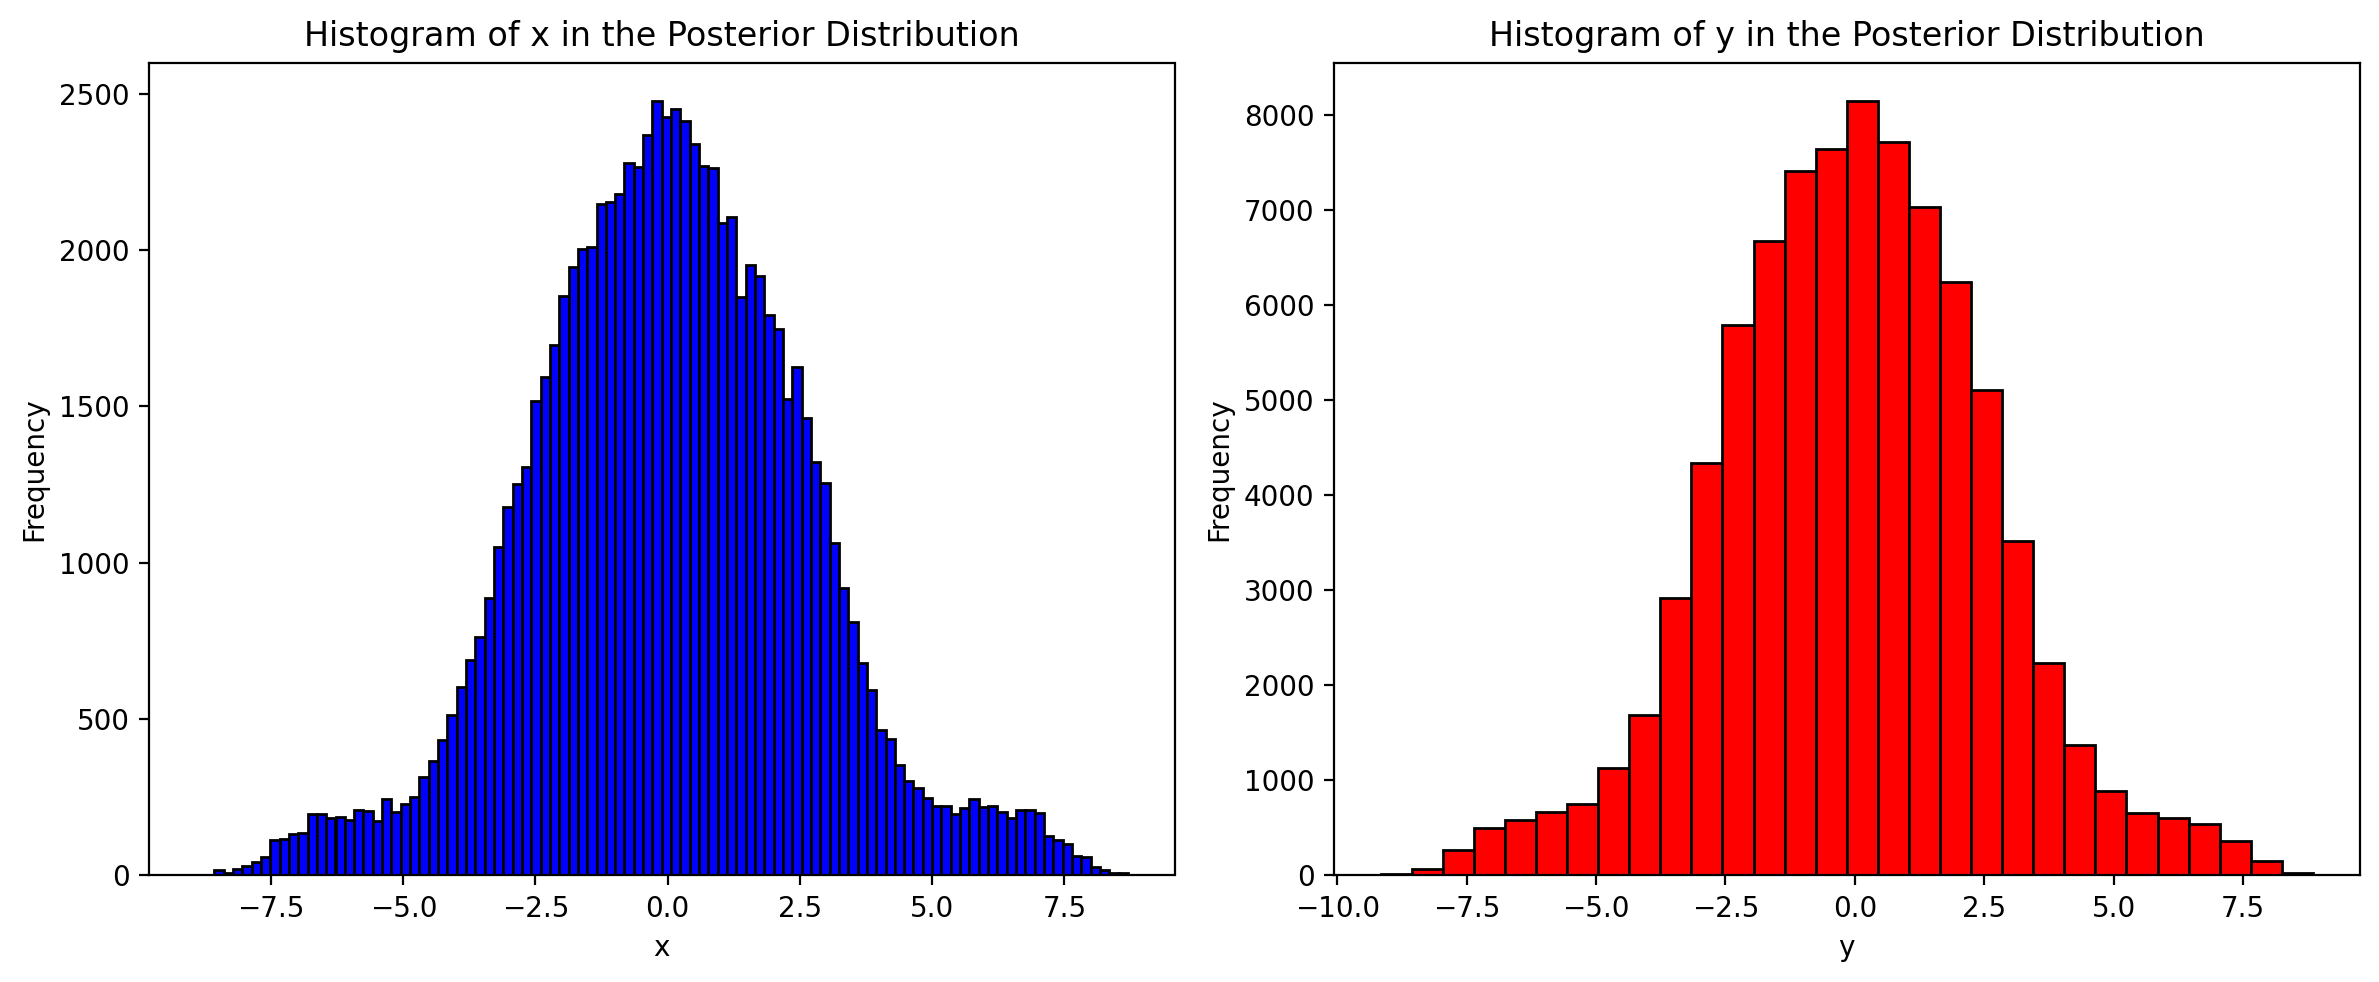

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(xpost, bins=100, color='blue', edgecolor= 'black')
plt.title('Histogram of x in the Posterior Distribution')
plt.xlabel('x')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(ypost, bins=30, color='red', edgecolor= 'black')
plt.title('Histogram of y in the Posterior Distribution')
plt.xlabel('y')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Shape Analysis: The histograms appear to be somewhat centered but not perfectly symmetrical, suggesting that the algorithm explores the parameter space around the minimum in a way that is influenced by the function's shape and the algorithm's parameters. The Markov chain Monte Carlo \(MCMC\) simulation is consistently converging to or spending a significant amount of time near certain values of x and y.


When we are optimising in more than one dimension we can also look for correlations between the 'best fit' parameters.  Here this can be done by looking at a scatter plot of the points in the posterior distribution.  Look at `?plt.scatter()` for information about scatter plots and consult the documentation for how to add colour and scale.

In the example below the points are given a colour that is scaled with the logarithm of the function we are minimising (*i.e.*, $\log_{10}\{\text{func_2d}(x,y)\}$).  This makes it abundantly clear where the minimum is and how narrow or wide this minimum is.  



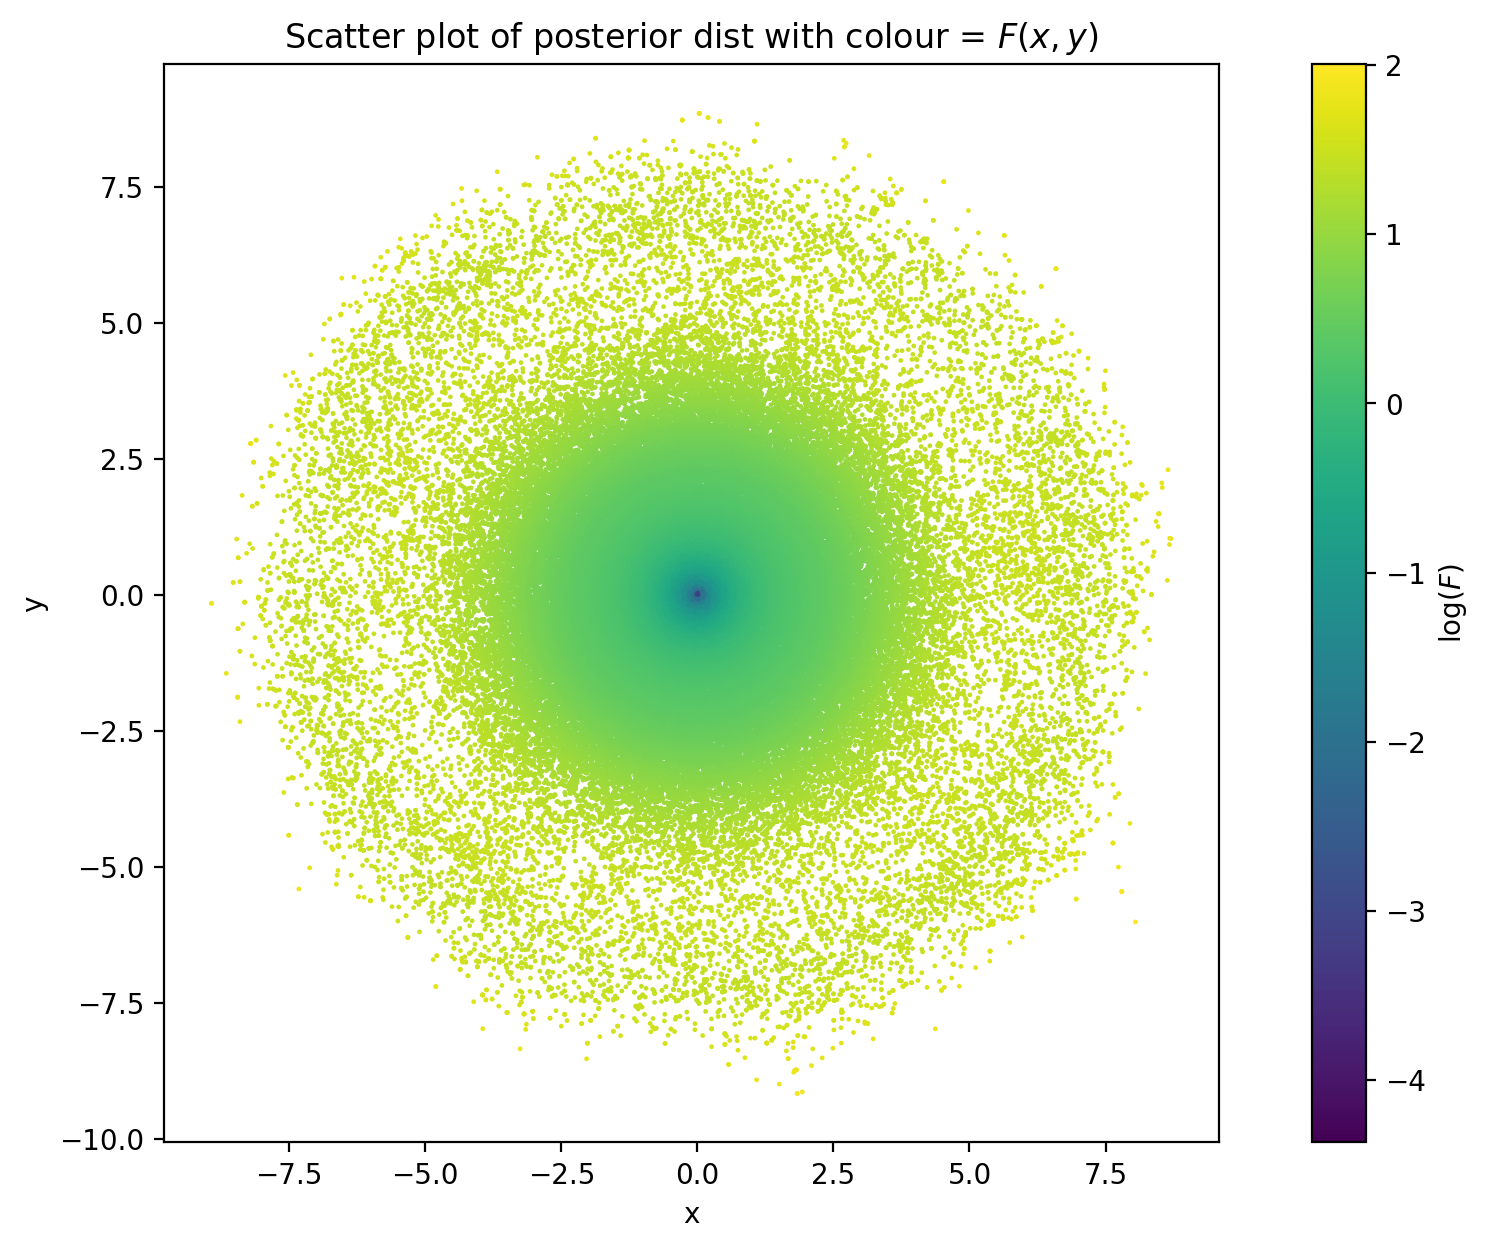

In [9]:
imin = np.argmin(Fpost)
imax = np.argmax(Fpost)

plt.figure()
plt.scatter(xpost,ypost,s=.5,
            c=np.log10(Fpost),
            vmin=np.log10(Fpost[imin]),
            vmax=np.log10(Fpost[imax]))
plt.colorbar(label='$\log(F)$')
plt.title('Scatter plot of posterior dist with colour = $F(x,y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')

▶ **CHECKPOINT 1**

## Non-linear fitting with the Metropolis-Hastings MCMC method

Here we look to fit a series of observed data points with a non-linear function. This is one of the most common numerical tasks in science.  There are several different numerical approaches for obtaining a fit (*e.g.*, non-linear Newton-Raphson), including some contained in Python modules (*e.g.*, `scipy.optimize.curve_fit`).

However, since the basic operation of fitting is to reduce the norm of the residuals between a fitting function and the data points (*i.e.*, the “chi-squared”, $\chi^2$), the Metropolis minimisation algorithm described above can readily be adapted to this problem. This is particularly useful in higher-dimensional parameter spaces.  Here we’ll use a slightly unorthodox Markov Chain Monte Carlo method to explore the range of parameters that are consistent with a simulated data set.



The task we will set ourselves is to fit the peak in the following data set:



In [10]:
data_x = np.array([0., 25., 50., 75., 100., 125., 150., 175., 200.])
data_y = np.array([10.6, 16., 45., 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])
data_y_err = np.array([4., 4., 4., 4., 4., 4., 4., 4., 4.])

We will fit a *Lorentzian* peak of the form

$$
L(x) = \frac{A}{(x - x_0)^2 + \gamma^2}.
$$

The Lorenztian function is commonly used when fitting intensity as a function of wavelength to identify spectral lines.  With a proper fit, the value of $x_o$ is the wavelength of of the central peak of an emmission or absorption line, $A$ is related to the intensity and $\gamma^2$ the width of the line.  So, finding best-fit values of these parameters is a way of measuring of the properties of spectral lines.

Here our fitting parameters are $\mathbf{p} = (A, x_0, \gamma^2)$ which we will represent in Python by `param = (A, x0, gammasq)`.

**Write, the Lorentzian function:**



In [11]:
def lorentzian(x, param):
    """Calculates a Lorentzian function at x with parameters param = (A, x0, gammasq)."""
    A, x0, gammasq = param
    return A / ((x - x0)**2 + gammasq)


**Construct a good guess at the initial parameters of $A$, $x_o$ and $\gamma^2$ that provide reasonably close fit to the data.  Plot them on top of the data.** This time let’s use the `errorbar()` function to plot including error bars.   *How do you construct a 'good guess' you ask?*   You examine the function for what the different parameters do (e.g., $x_o$, $A$ and $\gamma^2$) and attempt to estimate values from your plot of the actual data.   Your first few trial values may be wildly incorrect, but with some experimentation you can usually find values that result in a fit that more closely follows the data.  



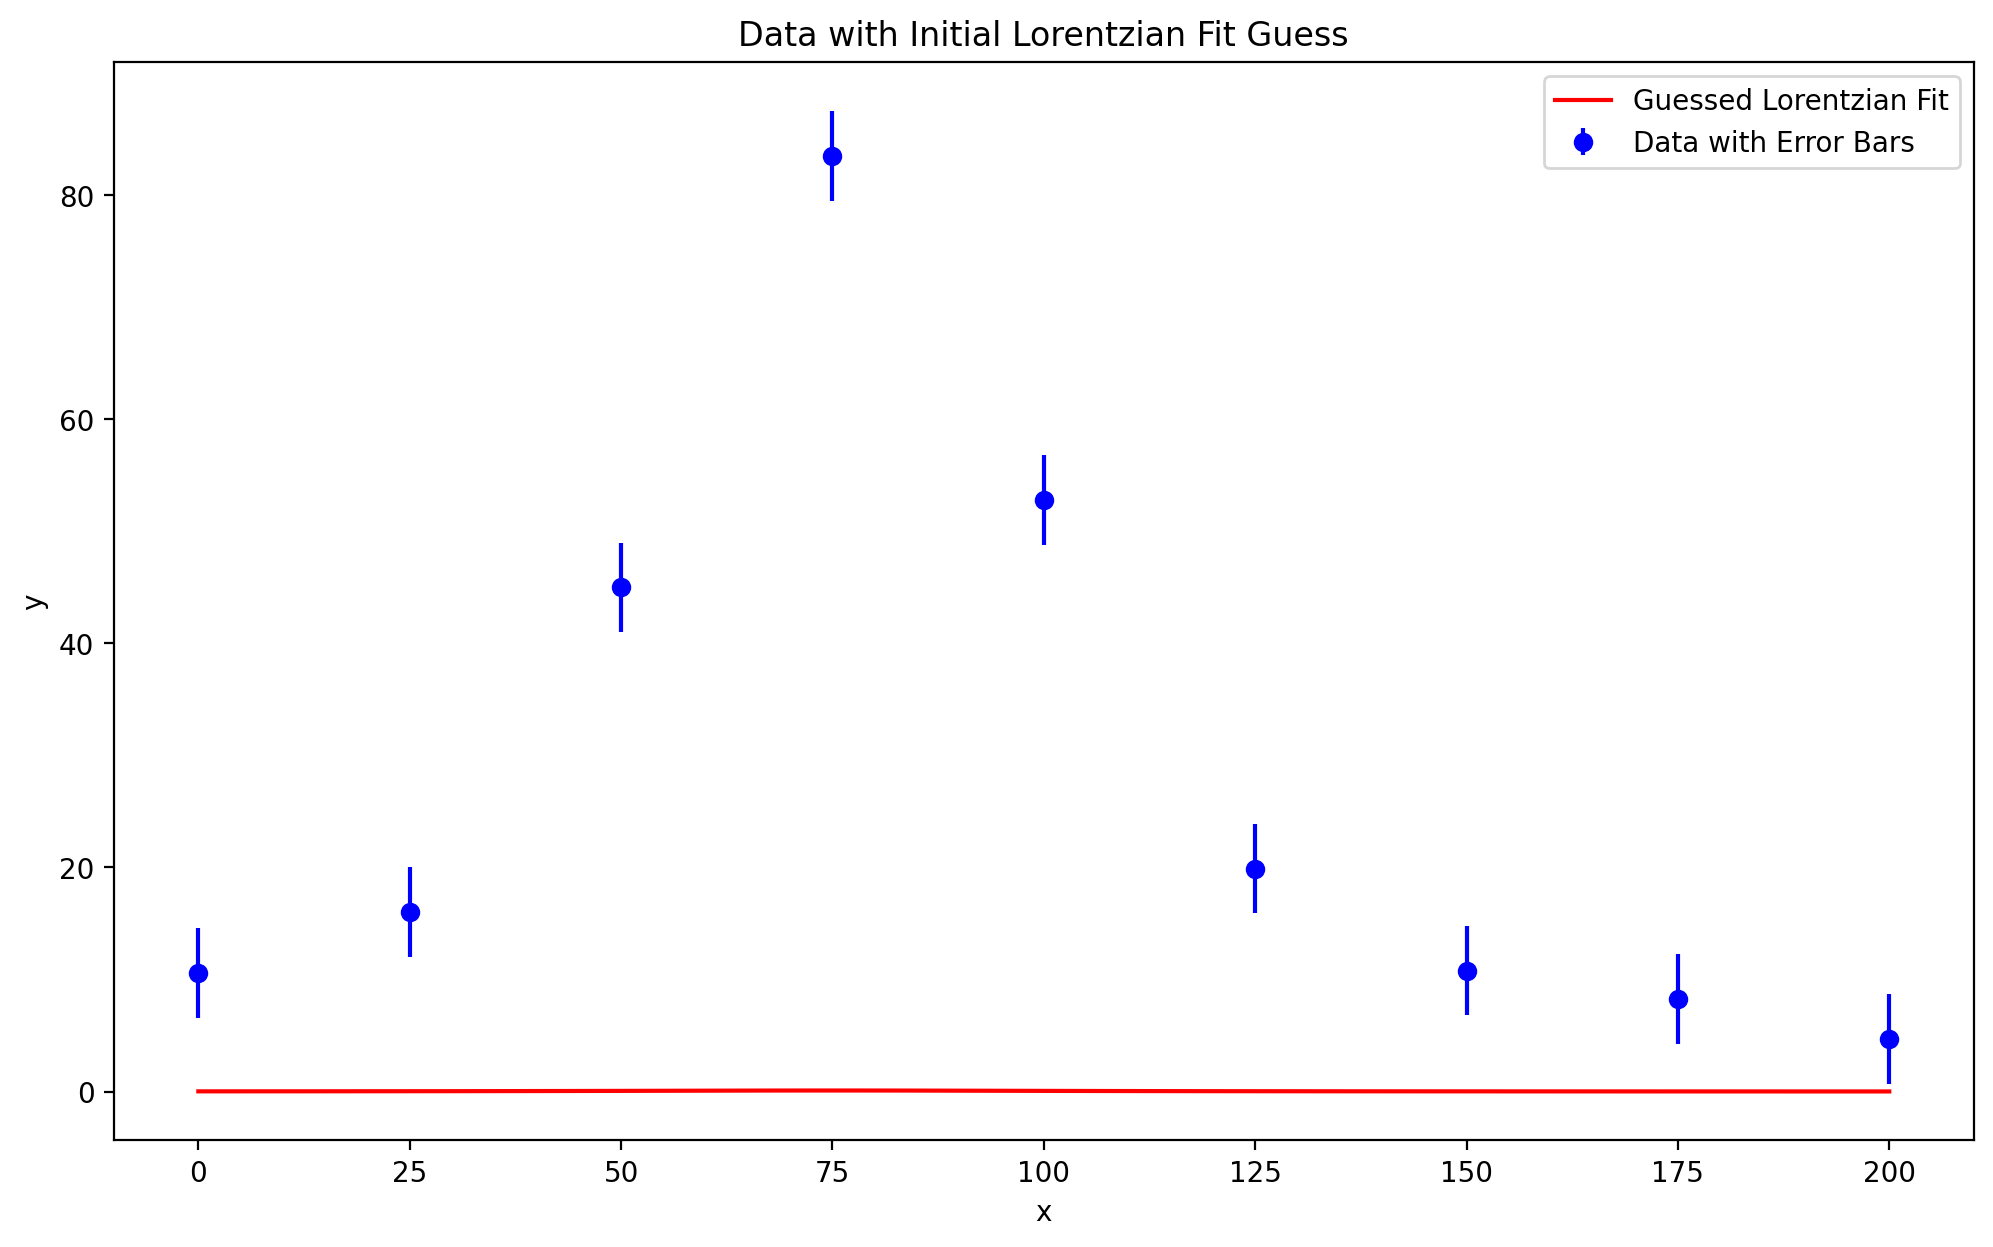

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.errorbar(data_x, data_y, yerr=data_y_err, fmt='o', label='Data with Error Bars', color='blue')

param_guess = (90, 75, 1000)

xplot = np.linspace(0, 200, 100)
yplot = lorentzian(xplot, param_guess)

plt.plot(xplot, yplot, label='Guessed Lorentzian Fit', color='red')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Data with Initial Lorentzian Fit Guess')
plt.legend()
plt.show()


### Assessing goodness of fit

Recall that we assess the goodness of fit with some norm of the residuals.  Here we will use the weighted chi-squared function,

$$
\chi^2 = \sum_i\left( \frac{(f(x_i) - y_i)}{\sigma_i} \right)^2
$$

where $\sigma_i$ is the error in the measured $y_i$ values.

**Compute the weighted $\chi^2$ of the fit.**  We will be doing this repeatedly, so it is a good idea to write a function for it.



In [13]:
def weighted_chi2(fitting_function, data, fit_params):
    data_x, data_y, data_y_err = data
    fit_y = fitting_function(data_x, fit_params)
    chi2 = np.sum(((fit_y - data_y) / data_y_err) ** 2)
    return chi2

chi2_value = weighted_chi2(lorentzian, (data_x, data_y, data_y_err), param_guess)
chi2_value


795.4869803152635

### MCMC Metropolis Fit

Here we will use the MCMC Metropolis algorithm described to develop a better fit.  In this example, instead of making a random walk through the $x-y$ plane as we did above, we will be 'walking' through the $A$, $x0$, $\gamma^2$ three-dimensional parameter space.  

Here, each “state” is a set of $A$, $x_0$, $\gamma^2$.  The random walk will sample parameter values away from the previous state.  The function we are attempting to minimise is the $\chi^2$ function.  Specifically, if the new state reduces the value of $\chi^2$ then we accept it.  If it results in an increase in $\chi^2$, we might still accept it if

$$
\text{random()}  < \exp\{-\beta(\chi^2_{i}-\chi^2_{i-1})\},
$$

where $i$ indicates the proposed state and $i-1$ the previous one.

**Using the code for minimizing `func_2d` above as a guide, adapt the code below so that it takes random steps through the three-dimensional parameter space.** The maximum step size for each parameter should be a separately adjustable parameter. 

(In practice, the step needs to be large enough to change the $\chi^2$ value enough to keep the random walk moving.  In other words, if the step size is too small, you don't walk far enough to find the global minimum.)



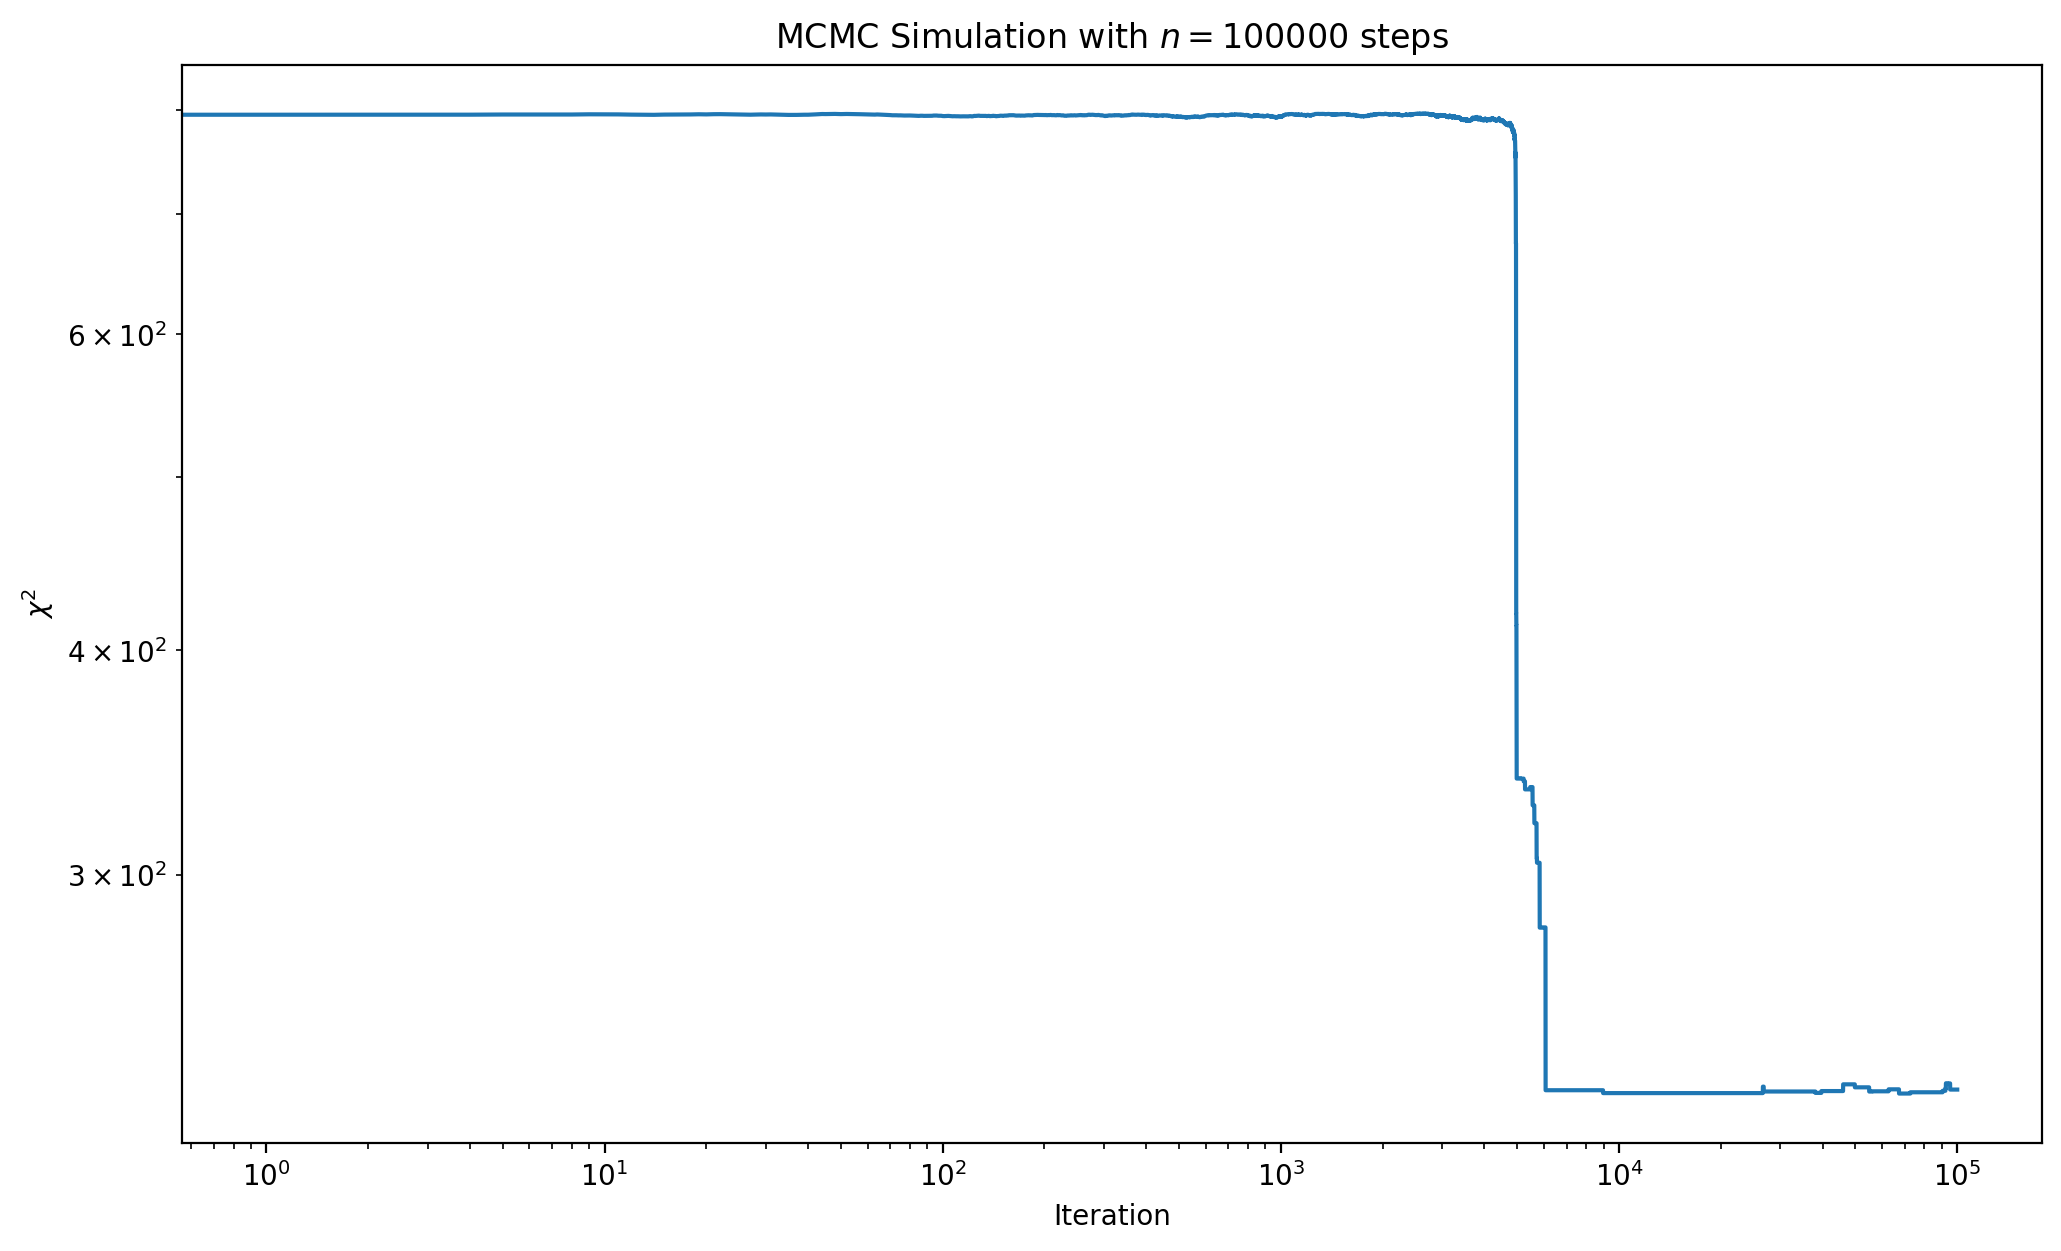

In [14]:
nsteps = 100_000
np.random.seed(1) 
beta = 1  

A_step_size = 10
x0_step_size = 5
gammasq_step_size = 50

data = (data_x, data_y, data_y_err)

current_A = 90
current_x0 = 75
current_gammasq = 1000
current_chisq = weighted_chi2(lorentzian, data, (current_A, current_x0, current_gammasq))

A, x0, gammasq, chisq = [current_A], [current_x0], [current_gammasq], [current_chisq]

for i in range(nsteps):
    A_step = np.random.uniform(-A_step_size, A_step_size)
    x0_step = np.random.uniform(-x0_step_size, x0_step_size)
    gammasq_step = np.random.uniform(-gammasq_step_size, gammasq_step_size)
    
    new_A = current_A + A_step
    new_x0 = current_x0 + x0_step
    new_gammasq = current_gammasq + gammasq_step
    
    new_chisq = weighted_chi2(lorentzian, data, (new_A, new_x0, new_gammasq))
    dchisq = new_chisq - current_chisq

    if dchisq < 0 or np.random.rand() < np.exp(-beta * dchisq):    
        current_A = new_A
        current_x0 = new_x0
        current_gammasq = new_gammasq
        current_chisq = new_chisq
        
    A.append(current_A)
    x0.append(current_x0)
    gammasq.append(current_gammasq)
    chisq.append(current_chisq)

plt.figure()
plt.title(f"MCMC Simulation with $n = {nsteps}$ steps")
plt.xlabel('Iteration')
plt.ylabel('$\chi^2$')
plt.loglog(chisq)
plt.show()


▶ **CHECKPOINT 2**



### Graphical analysis of the posterior

**Using the plot above, identify the place to slice and examine the properties of the posterior.** 

**With nicely formatted output, print the values of the fitting parameters ($A$, $x_o$, and $\gamma^2$) that minimise $\chi^2$ and provide the best fit.** If you are keen you may try comparing them to fit parameters obtained via another method (e.g.,  using `scipy.optimize.curve` to construct a fit).



In [15]:
islice = np.argmin(chisq) + 5000
A_post = A[islice:]
x0_post = x0[islice:]
gammasq_post = gammasq[islice:]
chisq_post = chisq[islice:]

imin = np.argmin(chisq_post)

best_fit_A = A_post[imin]
best_fit_x0 = x0_post[imin]
best_fit_gammasq = gammasq_post[imin]

best_fit_A, best_fit_x0, best_fit_gammasq


(1056.5606936433105, 62.72513347688573, -138.15920247934923)

A useful aspect of the posterior distribution is that it can illustrate how large a region of parameter space around the minimum provides a similar solution (e.g., value of $\chi^2$).  This can be used to estimate the uncertainties in the optimising or fitting parameters.

**Make a histogram of the posterior distribution of each of the fitting parameters.** 



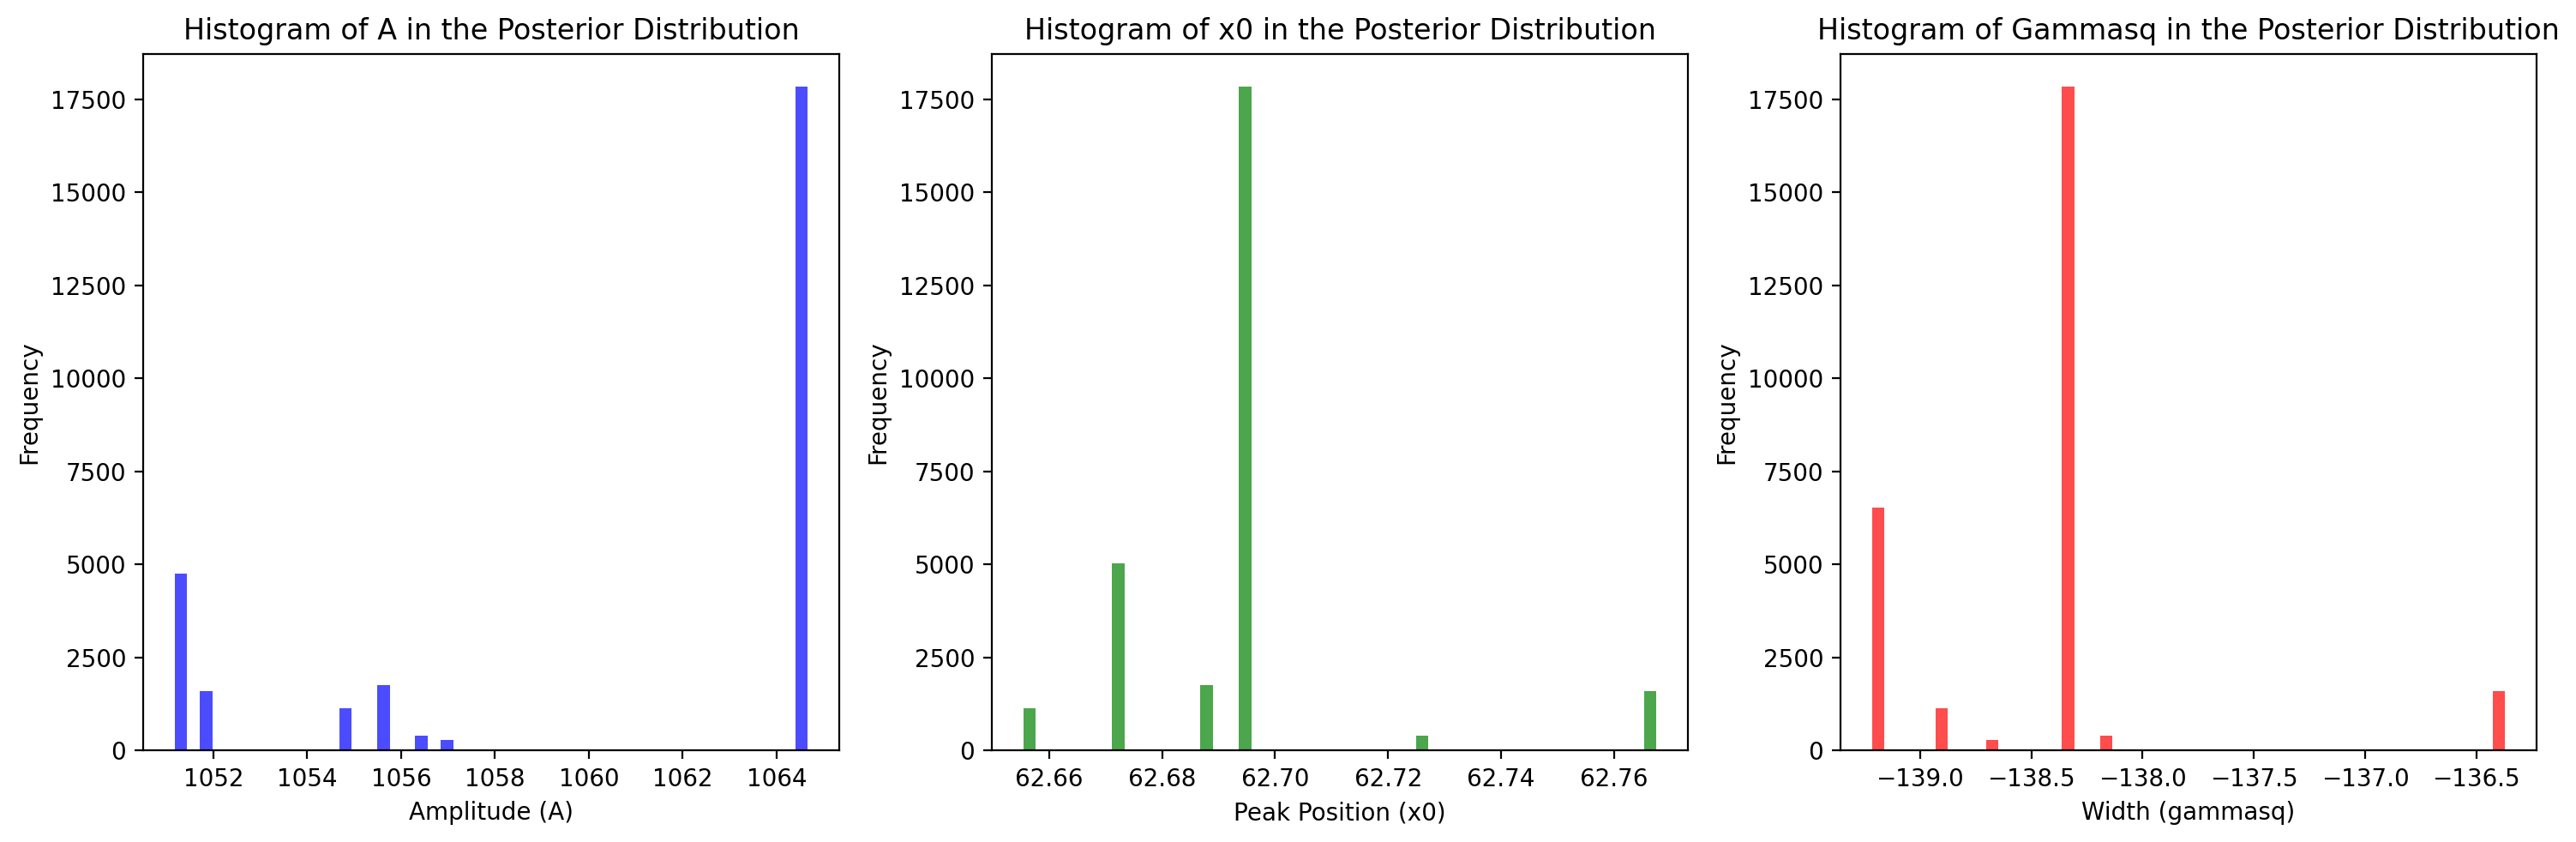

In [16]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(A_post, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of A in the Posterior Distribution')
plt.xlabel('Amplitude (A)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(x0_post, bins=50, color='green', alpha=0.7)
plt.title('Histogram of x0 in the Posterior Distribution')
plt.xlabel('Peak Position (x0)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(gammasq_post, bins=50, color='red', alpha=0.7)
plt.title('Histogram of Gammasq in the Posterior Distribution')
plt.xlabel('Width (gammasq)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


It is often useful to summarise these posterior distributions by *summary statistics*. The most commonly used, which you will have seen in your own experience, are the mean and standard deviation. However, these are most relevant when a distribution is approximately normal (Gaussian). A more general method is to present a *confidence interval*: that is, the range of values of a parameter that we’re (say) 95% sure the true value lies within. 

To do this in `numpy`, we use the `quantile` function. For instance, `np.quantile(A_post, 0.025)` will return a value greater than 2.5% of the values in the posterior distribution of $A$. Repeat this with the 97.5% percentile and you get the 95% confidence interval: the range containing 95% of the posterior distribution.

**Use this function to estimate the 95% confidence interval for each of the fitting parameters.**



In [17]:
A_lower = np.quantile(A_post, 0.025)
A_upper = np.quantile(A_post, 0.975)

x0_lower = np.quantile(x0_post, 0.025)
x0_upper = np.quantile(x0_post, 0.975)

gammasq_lower = np.quantile(gammasq_post, 0.025)
gammasq_upper = np.quantile(gammasq_post, 0.975)

A_conf_interval = (A_lower, A_upper)
x0_conf_interval = (x0_lower, x0_upper)
gammasq_conf_interval = (gammasq_lower, gammasq_upper)

A_conf_interval, x0_conf_interval, gammasq_conf_interval


((1051.1704853028746, 1064.669609652507),
 (62.65544452566803, 62.767495201646206),
 (-139.2161121112031, -136.37003697323652))

Another useful way of analysing MCMC posterior distributions is to identify any correlations between parameter values.

**Make scatter plots of $A$ vs $x_o$, $A$ vs $\gamma^2$, and $x_o$ vs $\gamma^2$. Do these plots indicate any correlation between these parameters?**



IndexError: list index out of range

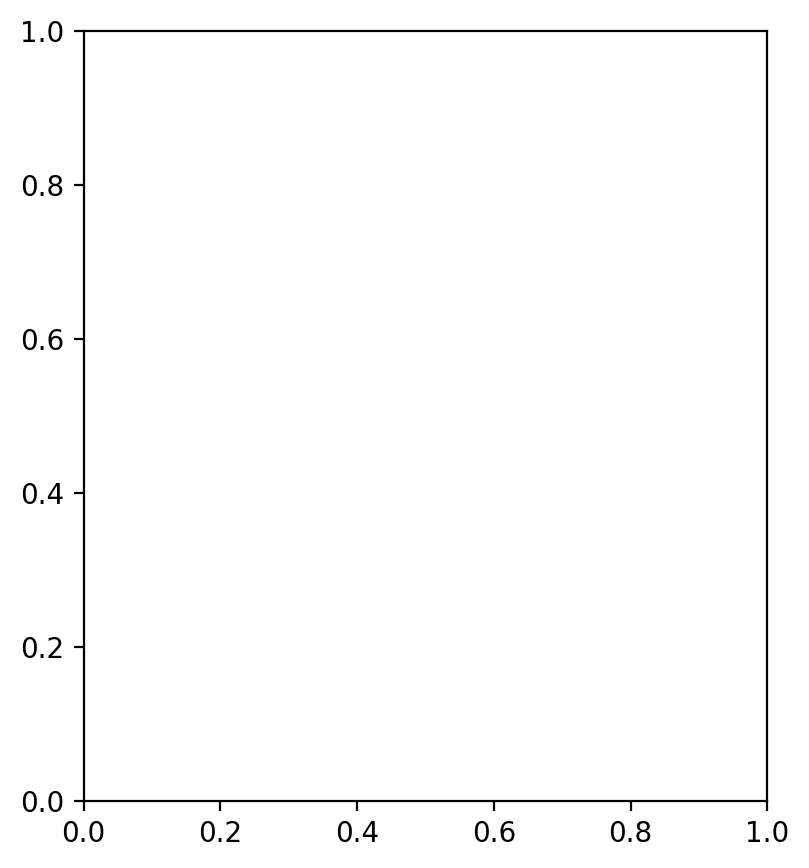

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(A_post, x0_post, s=0.5, c=chisq_post, vmin=chisq_post[imin], vmax=chisq_post[imax])
plt.colorbar(label='$\chi^2$')
plt.title('A vs x0')
plt.xlabel('Amplitude (A)')
plt.ylabel('Peak Position (x0)')

plt.subplot(1, 3, 2)
plt.scatter(A_post, gammasq_post, s=0.5, c=chisq_post, vmin=chisq_post[imin], vmax=chisq_post[imax])
plt.colorbar(label='$\chi^2$')
plt.title('A vs gammasq')
plt.xlabel('Amplitude (A)')
plt.ylabel('Width (gammasq)')

plt.subplot(1, 3, 3)
plt.scatter(x0_post, gammasq_post, s=0.5, c=chisq_post, vmin=chisq_post[imin], vmax=chisq_post[imax])
plt.colorbar(label='$\chi^2$')
plt.title('x0 vs gammasq')
plt.xlabel('Peak Position (x0)')
plt.ylabel('Width (gammasq)')

plt.tight_layout()
plt.show()


Finally, armed with the idea of a confidence interval, we can now do better than taking a single curve of best fit: we can look at the *range* of curves represented by the posterior distribution.

To calculate a 95% confidence interval of best fit, we perform three steps:

1. Calculate the curve represented by a relatively large number of samples from the posterior. Here we take 200 points spaced by 50 steps, to avoid any correlation between them so that the sample is as fair as possible.
1. Calculate the 2.5th and 97.5th percentiles, using the `quantile()` function from `numpy` as above.
1. Use the `fill_between()` function from `matplotlib` to plot the range between these percentiles: that is, the 95% confidence interval for the “true“ value at each point on the graph.

**The code below uses these steps to plot a curve showing the confidence interval at each point on the $x$ axis, together with the observed experimental data.** Check that you understand how it works.



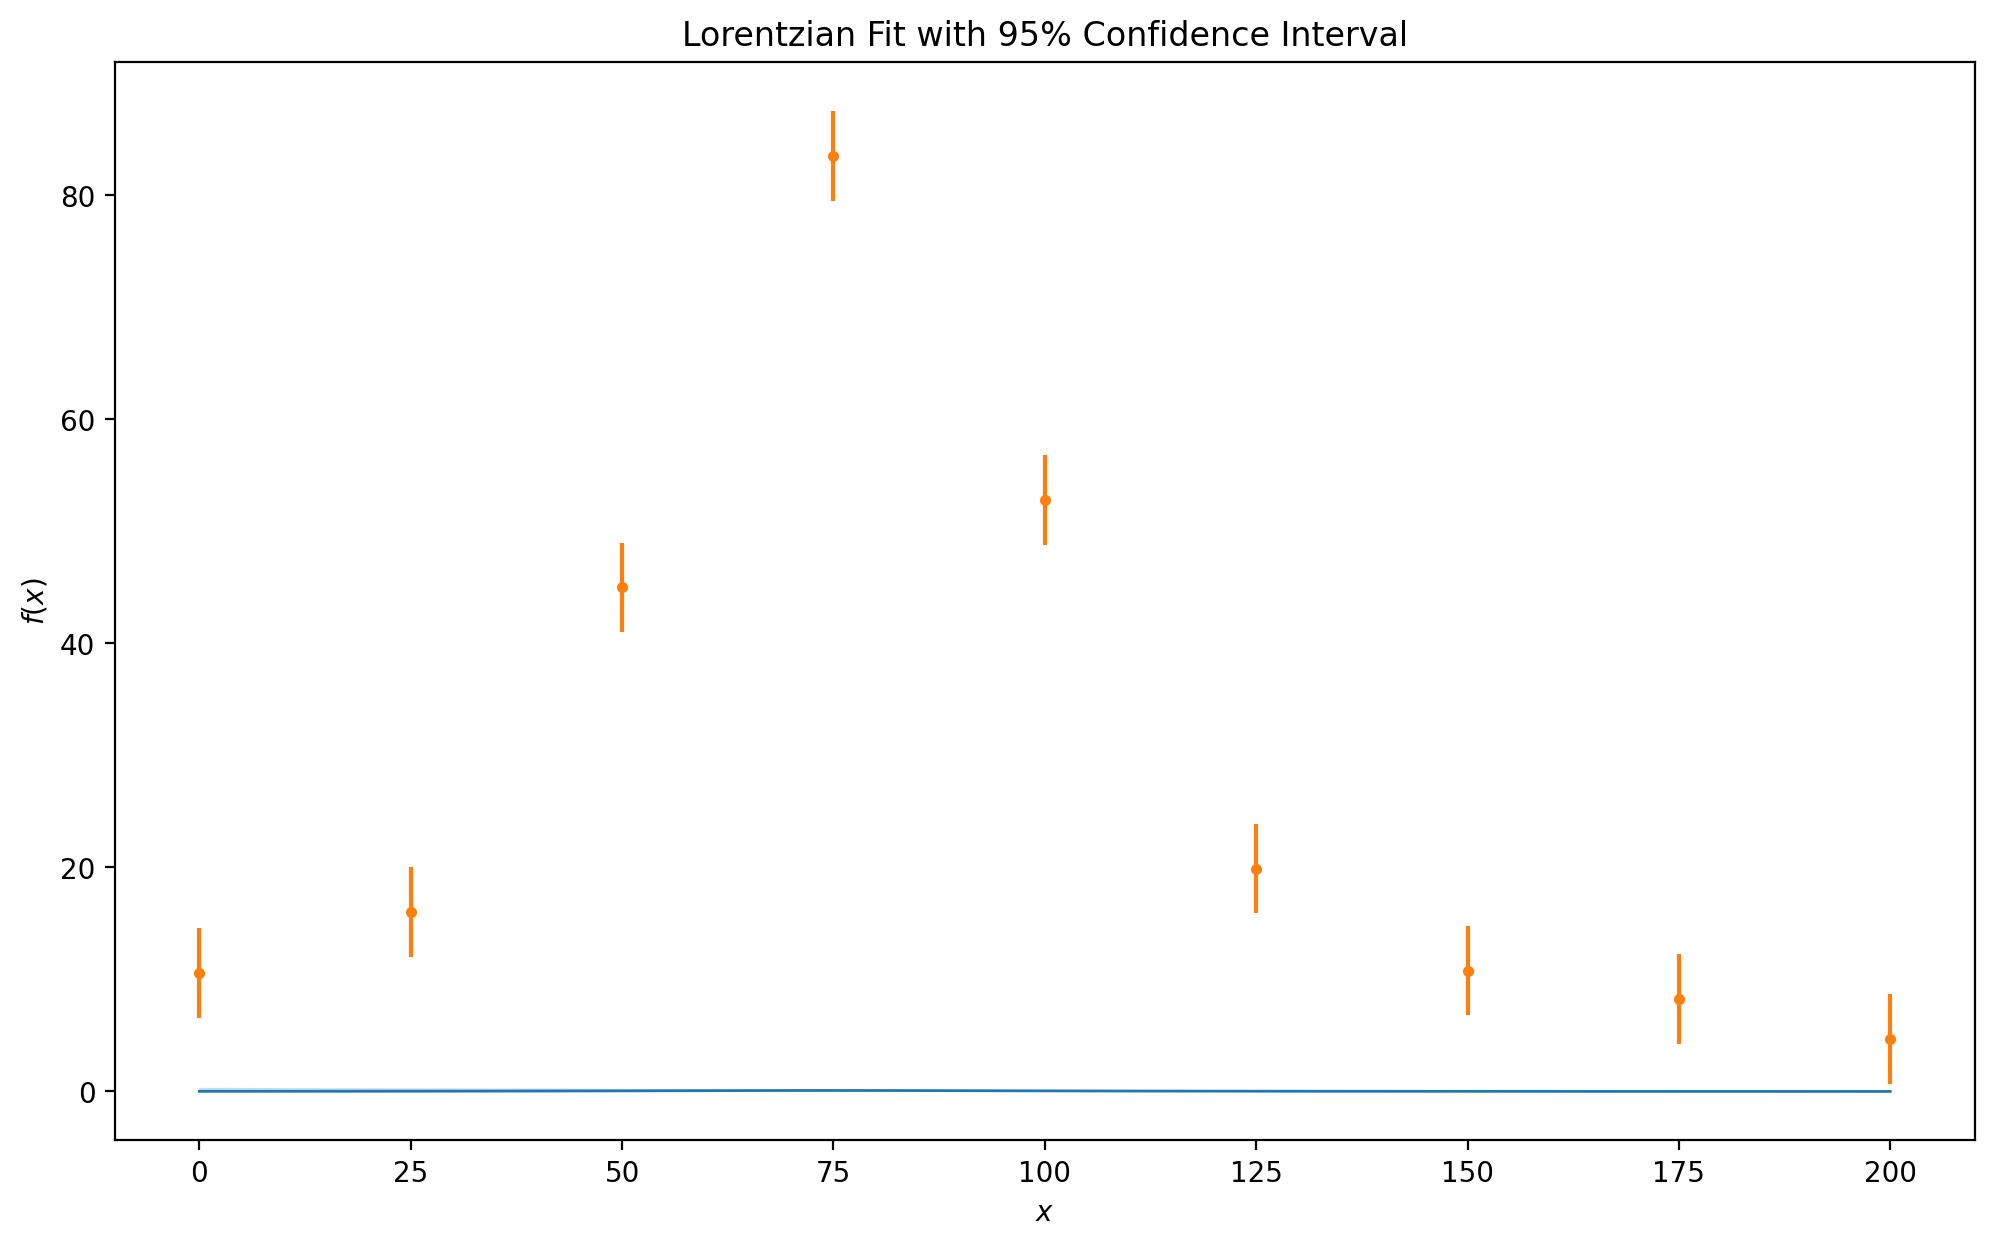

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def lorentzian(x, param):
    A, x0, gammasq = param
    return A / ((x - x0)**2 + gammasq)

def weighted_chi2(fitting_function, data, fit_params):
    data_x, data_y, data_y_err = data
    fit_y = fitting_function(data_x, fit_params)
    chi2 = np.sum(((fit_y - data_y) / data_y_err) ** 2)
    return chi2

data = (data_x, data_y, data_y_err)

xplot = np.linspace(0, 200, 100)

best_fit_A, best_fit_x0, best_fit_gammasq = 90, 75, 1000  
param_best = (best_fit_A, best_fit_x0, best_fit_gammasq)

np.random.seed(1)
nsteps = 1000
beta = 1
A_step_size = 10
x0_step_size = 5
gammasq_step_size = 50
current_A, current_x0, current_gammasq = 90, 75, 1000
current_chisq = weighted_chi2(lorentzian, data, (current_A, current_x0, current_gammasq))
A, x0, gammasq, chisq = [current_A], [current_x0], [current_gammasq], [current_chisq]

for i in range(nsteps):
    A_step = np.random.uniform(-A_step_size, A_step_size)
    x0_step = np.random.uniform(-x0_step_size, x0_step_size)
    gammasq_step = np.random.uniform(-gammasq_step_size, gammasq_step_size)
    
    new_A = current_A + A_step
    new_x0 = current_x0 + x0_step
    new_gammasq = current_gammasq + gammasq_step
    
    new_chisq = weighted_chi2(lorentzian, data, (new_A, new_x0, new_gammasq))
    
    dchisq = new_chisq - current_chisq
    if dchisq < 0 or np.random.rand() < np.exp(-beta * dchisq):    
        current_A, current_x0, current_gammasq, current_chisq = new_A, new_x0, new_gammasq, new_chisq
        
    A.append(current_A)
    x0.append(current_x0)
    gammasq.append(current_gammasq)
    chisq.append(current_chisq)

n_curves = 100
indices = [i for i in range(0, len(A), len(A) // n_curves)]
models = np.array([lorentzian(xplot, (A[i], x0[i], gammasq[i])) for i in indices])

model_lowerq = np.quantile(models, 0.025, axis=0)
model_upperq = np.quantile(models, 0.975, axis=0)

plt.figure()
plt.fill_between(xplot, model_lowerq, model_upperq, alpha=0.25)  
plt.plot(xplot, lorentzian(xplot, param_best), linewidth=1) 
plt.errorbar(data_x, data_y, fmt='.', yerr=data_y_err)

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('Lorentzian Fit with 95% Confidence Interval')
plt.show()


▶ **CHECKPOINT 3**

#### Extension

Try using `curve_fit` to provide an alternate solution.  Compare your fit parameters to those obtained via standard packages.  You could examine how sensitive the solution for both the MCMC method and via `curve_fit` is to your initial guess of parameters, and for the MCMC Metropolis solution to $\beta$ and the step size.

Look at the cell below for documentation to use `curve_fit`



In [20]:
from scipy.optimize import curve_fit
?curve_fit

Signature:
curve_fit(
    f,
    xdata,
    ydata,
    p0=None,
    sigma=None,
    absolute_sigma=False,
    check_finite=True,
    bounds=(-inf, inf),
    method=None,
    jac=None,
    *,
    full_output=False,
    **kwargs,
)
Docstring:
Use non-linear least squares to fit a function, f, to data.

Assumes ``ydata = f(xdata, *params) + eps``.

Parameters
----------
f : callable
    The model function, f(x, ...). It must take the independent
    variable as the first argument and the parameters to fit as
    separate remaining arguments.
xdata : array_like
    The independent variable where the data is measured.
    Should usually be an M-length sequence or an (k,M)-shaped array for
    functions with k predictors, and each element should be float
    convertible if it is an array like object.
ydata : array_like
    The dependent data, a length M array - nominally ``f(xdata, ...)``.
p0 : array_like, optional
    Initial guess for the parameters (length N). If None, then the
    initia

## Quiz Workspace
<hr style="border:4px solid black">